# Initial installs and imports

In [ ]:
# Instaling  the libraries used 
# WARNING: if you don't use this Notebook in Google Colab, this block might print some warnings

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2
!wget http://www.atarimania.com/roms/Roms.rar
!mkdir /content/ROM/
!unrar e /content/Roms.rar /content/ROM/
!python -m atari_py.import_roms /content/ROM/

from IPython.display import clear_output
clear_output()

In [ ]:
# Importing the libraries
import gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder    #records videos of episodes
import numpy as np
import matplotlib.pyplot as plt # Graphical library

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Configuring Pytorch

from collections import namedtuple, deque
from itertools import count
import math
import random

# WARNING: if you don't use this Notebook in Google Colab, comment out these two imports
from colabgymrender.recorder import Recorder # Allow to record videos in Google Colab
Recorder(gym.make("CartPole-v1"), './video') # Defining the video recorder
clear_output()

# Defining the model and optimization procedure

Firstly the ReplayBuffer and the DQN model is defined. Next separate optimization functions are defined for both DQN and DDQN.

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward',
                         'prev_states'))


class ReplayBuffer(object):

    def __init__(self, capacity, k): # initialise memory
        self.memory = deque([],maxlen=capacity)
        self.capacity = capacity
        self.k = k
    def push(self, *args): 
        """Save a incoming transition to memory"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):# Return a random sample from memory

        sample_batch = random.sample(self.memory, batch_size)

        return sample_batch

    def __len__(self): # Memory length
        return len(self.memory)

class DQN(nn.Module):

    def __init__(self, inputs, outputs, num_hidden, hidden_size):
        super(DQN, self).__init__()
        self.input_layer = nn.Linear(inputs, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden-1)])
        self.output_layer = nn.Linear(hidden_size, outputs)
    
    def forward(self, x):
        x.to(device)

        x = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        
        return self.output_layer(x)

In [ ]:
def optimize_model_DDQN(main_network, target_network, gamma, optimizer, memory, batch_size, k):
    """
    DDQN optimization function using main (policy) and target networks
    
    """
    if len(memory) < batch_size: # If memory less than batch size, end the optimization
      return                     # Get random transitions from memory    
    transitions = memory.sample(batch_size)                             # Currently Batch size is 1 so get 1 transition from memory
    #transitions are current state tensor, action taken, next state tensor, reward gotten
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))    


    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)

    # non_final_mask is a tensor that says either True or False if the current state was non final or not
    # Can safely omit the condition below to check that not all states in the
    # sampled batch are terminal whenever the batch size is reasonable and
    # there is virtually no chance that all states in the sampled batch are 
    # terminal
    if sum(non_final_mask) > 0:
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
    else:
        non_final_next_states = torch.empty(0,state_dim).to(device)

    state_batch = torch.cat(batch.state) # Get the states of current batch
    action_batch = torch.cat(batch.action) # Get the actions of current batch
    reward_batch = torch.cat(batch.reward) # Get the rewards of current batch
    prev_states_batch = torch.cat(batch.prev_states).reshape(-1, k*4)

    state_memory_batch = torch.cat((prev_states_batch, state_batch), 1)
    non_final_next_state_memory = torch.cat((state_memory_batch[non_final_mask][:, -k*4:], non_final_next_states),1)
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    # You get 2 values from policy_net(state_batch) and it takes the max one

    state_action_values = main_network(state_memory_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    # Firstly here initialise
    next_state_values = torch.zeros(batch_size, device=device)
    chosen_actions = torch.zeros(batch_size,dtype = int, device=device)

    with torch.no_grad():
        # Once again can omit the condition if batch size is large enough
        if sum(non_final_mask) > 0:
            chosen_actions[non_final_mask] = torch.argmax(target_network(non_final_next_state_memory), 1)
            actions_non_final = chosen_actions[non_final_mask].unsqueeze(1)
            next_state_values[non_final_mask] = main_network(non_final_next_state_memory).gather(1, actions_non_final).flatten()
        else:
            next_state_values = torch.zeros_like(next_state_values)

    # Compute the expected Q values

    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute loss
    criterion = torch.nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    # Limit magnitude of gradient for update step
    for param in main_network.parameters():
        param.grad.data.clamp_(-1, 1)

    optimizer.step()

In [ ]:
def optimize_model_DQN(main_network, target_network, gamma, optimizer, memory, batch_size, k):
    """
    DQN optimization function using main (policy) and target networks
    
    """
    if len(memory) < batch_size: # If memory less than batch size, end the optimization
        return                   
    transitions = memory.sample(batch_size) # Get random transitions from memory                                     # Currently Batch size is 1 so get 1 transition from memory
    # transitions are current state tensor, action taken, next state tensor, reward gotten
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))    

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)

    #non_final_mask is a tensor that says either True or False if the current state was non final or not
    # Can safely omit the condition below to check that not all states in the
    # sampled batch are terminal whenever the batch size is reasonable and
    # there is virtually no chance that all states in the sampled batch are 
    # terminal
    if sum(non_final_mask) > 0:
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
    else:
        non_final_next_states = torch.empty(0,state_dim).to(device)

    state_batch = torch.cat(batch.state) # Get the states of current batch
    action_batch = torch.cat(batch.action) # Get the actions of current batch
    reward_batch = torch.cat(batch.reward) # Get the rewards of current batch
    prev_states_batch = torch.cat(batch.prev_states).reshape(-1, k*4)

    state_memory_batch = torch.cat((prev_states_batch, state_batch), 1)
    non_final_next_state_memory = torch.cat((state_memory_batch[non_final_mask][:, -k*4:], non_final_next_states),1)
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    # You get 2 values from policy_net(state_batch) and it takes the max one
    state_action_values = main_network(state_memory_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    # Firstly here initialise
    next_state_values = torch.zeros(batch_size, device=device)
    
    with torch.no_grad():
        # Once again can omit the condition if batch size is large enough
        if sum(non_final_mask) > 0:
            next_state_values[non_final_mask] = target_network(non_final_next_state_memory).max(1)[0].detach()
        else:
            next_state_values = torch.zeros_like(next_state_values)

    # Compute the expected Q values

    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute loss
    criterion = torch.nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    # Limit magnitude of gradient for update step
    for param in main_network.parameters():
        param.grad.data.clamp_(-1, 1)

    optimizer.step()

Next defined functions for selecting an action by the networks and separate learning rate schedule for ddqn case

In [ ]:
def select_action(state_action, state, policy_net,n_actions , current_eps=0):
    sample = random.random()
    eps_threshold = current_eps
    state_mem = torch.cat((state_action.flatten().unsqueeze(0), state.flatten().unsqueeze(0)),1)
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return torch.tensor([[policy_net(state_mem).argmax().item()]], device=device, dtype=torch.long)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [ ]:
def ddqn_schedule(mean_rew):
  if mean_rew < 100:
    epsilon = 0.0001
    learning_rate = 0.001
    
  elif mean_rew <200:
    epsilon = 0.0001
    learning_rate = 0.0001
    
  elif mean_rew < 300:
    epsilon = 0.0001
    learning_rate = 0.0001
    
  elif mean_rew < 400:
    epsilon = 0.0
    learning_rate = 0.00001

  else:
    epsilon = 0
    learning_rate = 0.000001
  return epsilon, learning_rate

# Training the network and results

First the function for training the network is constructed, next a plotting function is defined and running the final cell trains the networks and plots the results.

In [ ]:
def train_network(num_episodes,batch_size, gamma, k, epsilon, num_hidden_layers,size_hidden_layers,learning_rate, ddqn, buffer_size):
# Get number of states and actions from gym action space
  env = gym.make("CartPole-v1")
  env.reset()
  state_dim = len(env.state)    #x, x_dot, theta, theta_dot
  n_actions = env.action_space.n
  env.close()

  main_network = DQN((state_dim)*(k+1), n_actions, num_hidden_layers, size_hidden_layers).to(device)
  target_network = DQN((state_dim)*(k+1), n_actions, num_hidden_layers, size_hidden_layers).to(device)

  optimizer = optim.Adam(main_network.parameters(), learning_rate)
  memory = ReplayBuffer(buffer_size, k)
  episode_durations = []
  for i_episode in range(num_episodes):
    if i_episode % 100 == 0:
        print("episode ", i_episode, "/", num_episodes)
    if i_episode % 10 == 0:
        target_network.load_state_dict(main_network.state_dict())
    # Initialize the environment and state
    env.reset()
    state_memory = torch.zeros((k,4))
    state = torch.tensor(env.state).float().unsqueeze(0).to(device) # Get the current state values
    
    if ddqn: # Epsilon and learning rate schedule if DDQN
      if i_episode >= 120:
        mean_rew = np.mean(episode_durations[-5:])
        epsilon, learning_rate_mod = ddqn_schedule(mean_rew)
        for g in optimizer.param_groups:
          g['lr'] = learning_rate_mod
      else:
        epsilon = epsilon * 0.98
    else: # Epsilon schedule if DQN
      if i_episode >= 50:
        epsilon = epsilon * 0.985
      else:
        epsilon = epsilon * 0.975

    for t in count():
        # Select and perform an action
        action = select_action(state_memory[-k:],state, main_network,n_actions, epsilon)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        # Observe new state
        if not done:
            next_state = torch.tensor(env.state).float().unsqueeze(0).to(device)
        else:
            next_state = None
        # Store the transition in memory
        memory.push(state, action, next_state, reward,state_memory[-k:].flatten())
        if ddqn:
          optimize_model_DDQN(main_network, target_network, gamma, optimizer, memory, batch_size, k)
        else: 
          optimize_model_DQN(main_network, target_network, gamma, optimizer, memory, batch_size, k)
        # Move to the next state
        state_memory = torch.cat((state_memory, state),0)
        state = next_state
        # Perform one step of the optimization (on the policy network)
        if done:
            break
    episode_durations.append(t)
  target_network = main_network

  plt.figure()
  plt.plot(episode_durations, color = "steelblue", label="Rewards")
  plt.title("Learning curve")
  plt.xlabel("Number of episodes")
  plt.ylabel("Total summed rewards")
  plt.legend([" Total Rewards"],
         loc="lower right", bbox_to_anchor=(1, 0.1), prop={"size":8})
  plt.grid()
  plt.box(False)
  plt.show()

  env.close()
  return (main_network, target_network, episode_durations)


In [ ]:
def plot_graph(title, durations):
  mean_rewards = np.average(durations, axis = 0)
  std_rewards = np.std(durations, axis = 0)
  
  print(title)
  plt.figure()
  plt.plot(mean_rewards, color = "steelblue", label="forestgreen")
  plt.fill_between(range(len(durations[0])), mean_rewards-std_rewards, mean_rewards+std_rewards, alpha = 0.5, color = "forestgreen")
  plt.legend([" Mean rewards", "Standard deviation"],
            loc="lower right", bbox_to_anchor=(1, 0.1), prop={"size":8})

  plt.xlabel("Number of episodes")
  plt.ylabel("Total summed rewards")
  plt.grid()
  plt.box(False)
  plt.show()
  return mean_rewards, std_rewards

episode  0 / 200
episode  100 / 200


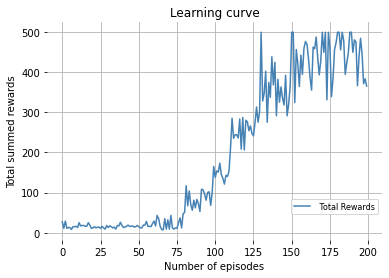

In [ ]:
num_episodes = 200
batch_size = 64
gamma = 0.999
k = 1
epsilon = 1
num_hidden_layers = 2
size_hidden_layers = 256
ddqn = False
learning_rate = 0.0001
size_buffer = 500000

main_network_fin, target_network_fin, episode_duration = train_network(num_episodes,batch_size, gamma, k,
           epsilon, num_hidden_layers,size_hidden_layers,
           learning_rate, ddqn, buffer_size = size_buffer)